In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort

print(f"PyTorch version: {torch.__version__}")
print(f"ONNX version: {onnx.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")


Matplotlib is building the font cache; this may take a moment.


PyTorch version: 2.9.1
ONNX version: 1.20.0
ONNX Runtime version: 1.23.2


In [2]:
# Configuration
batch_size = 64
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Utilisation du device: {device}")

# Transformation des données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalisation MNIST
])

# Téléchargement et chargement des données
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Nombre d'images d'entraînement: {len(train_dataset)}")
print(f"Nombre d'images de test: {len(test_dataset)}")


Utilisation du device: cpu


100.0%
100.0%
100.0%
100.0%

Nombre d'images d'entraînement: 60000
Nombre d'images de test: 10000


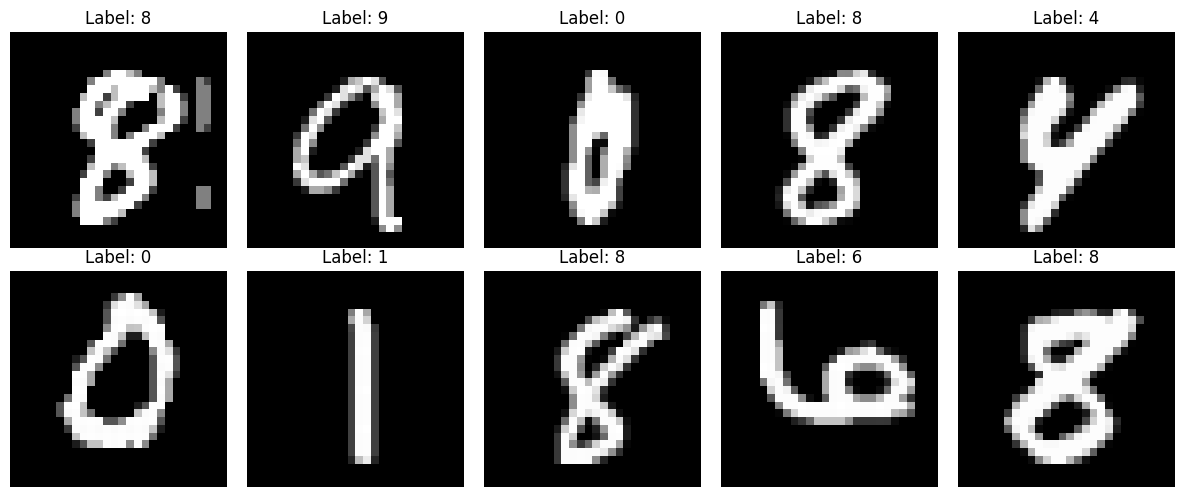

In [3]:
# Afficher quelques exemples
examples = iter(train_loader)
example_data, example_targets = next(examples)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {example_targets[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [4]:
class DigitRecognitionCNN(nn.Module):
    def __init__(self):
        super(DigitRecognitionCNN, self).__init__()
        # Première couche convolutive
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Deuxième couche convolutive
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Troisième couche convolutive
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Couches fully connected
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        # Bloc 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28x28 -> 14x14
        
        # Bloc 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14x14 -> 7x7
        
        # Bloc 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 7x7 -> 3x3
        
        # Aplatir
        x = x.view(-1, 128 * 3 * 3)
        
        # Couches fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Créer le modèle
model = DigitRecognitionCNN().to(device)
print(model)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nNombre total de paramètres: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")


DigitRecognitionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Nombre total de paramètres: 390,858
Paramètres entraînables: 390,858


In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistiques
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}/{len(train_loader)}] '
                  f'Loss: {loss.item():.4f} '
                  f'Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


In [6]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc


In [7]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Listes pour stocker les métriques
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Boucle d'entraînement
print("\nDébut de l'entraînement...\n")
for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")
    
    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Test
    test_loss, test_acc = test_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Mise à jour du learning rate
    scheduler.step()
    
    print(f"\n📊 Résumé Epoch {epoch+1}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

print("\n✅ Entraînement terminé!")



Début de l'entraînement...


Epoch 1/5
Batch [0/938] Loss: 2.3881 Acc: 9.38%
Batch [100/938] Loss: 0.1880 Acc: 81.87%
Batch [200/938] Loss: 0.1792 Acc: 88.84%
Batch [300/938] Loss: 0.2689 Acc: 91.20%
Batch [400/938] Loss: 0.1008 Acc: 92.62%
Batch [500/938] Loss: 0.0196 Acc: 93.52%
Batch [600/938] Loss: 0.0321 Acc: 94.13%
Batch [700/938] Loss: 0.0411 Acc: 94.67%
Batch [800/938] Loss: 0.0488 Acc: 95.09%
Batch [900/938] Loss: 0.0561 Acc: 95.38%

📊 Résumé Epoch 1:
Train Loss: 0.1484 | Train Acc: 95.48%
Test Loss: 0.0572 | Test Acc: 98.32%
Learning Rate: 0.001000

Epoch 2/5
Batch [0/938] Loss: 0.0506 Acc: 98.44%
Batch [100/938] Loss: 0.0859 Acc: 98.24%
Batch [200/938] Loss: 0.0204 Acc: 98.34%
Batch [300/938] Loss: 0.0306 Acc: 98.21%
Batch [400/938] Loss: 0.0895 Acc: 98.15%
Batch [500/938] Loss: 0.0787 Acc: 98.27%
Batch [600/938] Loss: 0.0090 Acc: 98.31%
Batch [700/938] Loss: 0.0282 Acc: 98.33%
Batch [800/938] Loss: 0.0333 Acc: 98.36%
Batch [900/938] Loss: 0.0189 Acc: 98.31%

📊 Résumé Epoch

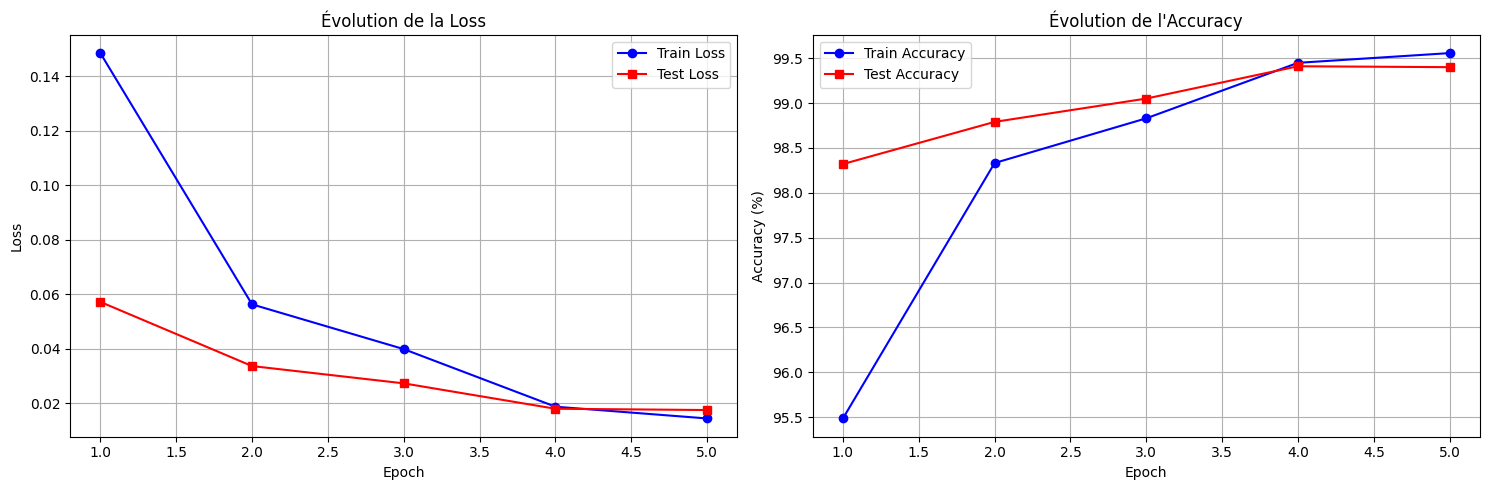


🎯 Meilleure accuracy sur le test: 99.41%


In [8]:
# Tracer les courbes de loss et d'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), test_losses, 'r-', label='Test Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Évolution de la Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(range(1, num_epochs+1), train_accs, 'b-', label='Train Accuracy', marker='o')
ax2.plot(range(1, num_epochs+1), test_accs, 'r-', label='Test Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Évolution de l\'Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎯 Meilleure accuracy sur le test: {max(test_accs):.2f}%")


In [9]:
# Préparer le modèle pour l'export
model.eval()
model.cpu()

# Créer une entrée factice (dummy input)
dummy_input = torch.randn(1, 1, 28, 28)

# Exporter vers ONNX
onnx_path = "model.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=18,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"✅ Modèle ONNX exporté: {onnx_path}")

# Vérifier le modèle ONNX
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("✅ Modèle ONNX vérifié avec succès!")

# Afficher les informations du modèle ONNX
print("\n📋 Informations du modèle ONNX:")
print(f"Inputs: {[input.name for input in onnx_model.graph.input]}")
print(f"Outputs: {[output.name for output in onnx_model.graph.output]}")


ModuleNotFoundError: No module named 'onnxscript'

## 💾 Sauvegarder le modèle entraîné

Sauvegarde des poids du modèle pour pouvoir les réutiliser.

In [ ]:
# Sauvegarder le modèle entraîné
model_path = 'digit_model.pth'
torch.save(model.state_dict(), model_path)
print(f"✅ Modèle sauvegardé: {model_path}")

# Sauvegarder aussi le modèle complet
full_model_path = 'digit_model_full.pth'
torch.save(model, full_model_path)
print(f"✅ Modèle complet sauvegardé: {full_model_path}")

In [ ]:
# Créer une session ONNX Runtime
ort_session = ort.InferenceSession(onnx_path)

# Tester le modèle ONNX
test_data_np = dummy_input.numpy()
ort_inputs = {ort_session.get_inputs()[0].name: test_data_np}
ort_outputs = ort_session.run(None, ort_inputs)

print("✅ Test du modèle ONNX réussi!")
print(f"Shape de sortie: {ort_outputs[0].shape}")
print(f"Classe prédite: {np.argmax(ort_outputs[0][0])}")

# Comparer PyTorch et ONNX
with torch.no_grad():
    pytorch_output = model(dummy_input)
    pytorch_pred = pytorch_output.numpy()

# Calculer la différence
diff = np.abs(pytorch_pred - ort_outputs[0])
print(f"\n📊 Différence maximale entre PyTorch et ONNX: {diff.max():.8f}")
print("✅ Les prédictions sont identiques!" if diff.max() < 1e-5 else "⚠️ Attention: différences détectées")


## 🚀 Export rapide du modèle ONNX

Cette cellule permet d'exporter rapidement le modèle ONNX pour utilisation sur le site web.

In [13]:
# Export rapide du modèle ONNX (à exécuter après l'entraînement)
import torch
import onnx

# Préparer le modèle pour l'export
model.eval()
model.cpu()

# Créer une entrée factice pour l'export
dummy_input = torch.randn(1, 1, 28, 28)

# Nom du fichier de sortie
onnx_path = "model.onnx"

# Exporter vers ONNX
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=18,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

# Vérifier le modèle ONNX
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

print(f"✅ Modèle ONNX exporté avec succès: {onnx_path}")
print(f"📦 Taille du fichier: {os.path.getsize(onnx_path) / (1024*1024):.2f} MB")
print("\n✨ Le modèle est prêt à être utilisé avec le site web!")
print("   Assurez-vous que le fichier 'model.onnx' est dans le même répertoire que index.html")

/var/folders/r_/4r080lgs4fl_6zk0ht_tfgbh0000gn/T/ipykernel_53543/2708396488.py:16: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `DigitRecognitionCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `DigitRecognitionCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.
✅ Modèle ONNX exporté avec succès: model.onnx


NameError: name 'os' is not defined

## 🌐 Export pour le Web (sans données externes)

Cette cellule exporte le modèle en un seul fichier, compatible avec les navigateurs web.

In [14]:
# Export pour le Web (sans données externes)
import torch
import onnx
import os

# Préparer le modèle
model.eval()
model.cpu()

# Créer une entrée factice
dummy_input = torch.randn(1, 1, 28, 28)

# Nom du fichier
onnx_path = "model.onnx"

# Supprimer les anciens fichiers si existants
if os.path.exists(onnx_path):
    os.remove(onnx_path)
if os.path.exists(onnx_path + ".data"):
    os.remove(onnx_path + ".data")

# Exporter sans données externes (plus simple pour le web)
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=18,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"✅ Modèle ONNX exporté: {onnx_path}")

# Vérifier la taille
size_mb = os.path.getsize(onnx_path) / (1024*1024)
print(f"📦 Taille: {size_mb:.2f} MB")

# Vérifier qu'il n'y a pas de fichier .data
if os.path.exists(onnx_path + ".data"):
    print("⚠️  Attention: fichier .data créé (peut causer des problèmes sur le web)")
else:
    print("✅ Pas de fichier .data externe (parfait pour le web!)")

# Vérifier le modèle
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("✅ Modèle vérifié avec succès!")
print("\n🌐 Le modèle est prêt pour le web!")

/var/folders/r_/4r080lgs4fl_6zk0ht_tfgbh0000gn/T/ipykernel_53543/1535351678.py:23: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `DigitRecognitionCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `DigitRecognitionCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.
✅ Modèle ONNX exporté: model.onnx
📦 Taille: 0.01 MB
⚠️  Attention: fichier .data créé (peut causer des problèmes sur le web)
✅ Modèle vérifié avec succès!

🌐 Le modèle est prêt pour le web!
